 ---
 # Transition Rates: Problem Definition, Intuition, and Application

 This first cell is a **conceptual overview** (with equations in comments).
 We will review what transition rates are, how they connect to probabilities,
 and how they are applied in the demon + bit tape model.

 Think of this as a "problem definition" cell – the roadmap before coding.
 ## What is a transition rate?

 - Discrete-state systems (like a demon in states {u, d}) jump randomly.
 - A **transition rate** R_{i->j} is the probability *per unit time*
   that the system jumps from state i to state j.

 For small Δt:
   P{i→j in Δt} ≈ R_{i->j} * Δt     (for i ≠ j)
   P{i→i in Δt} ≈ 1 - Σ_{j≠i} R_{i->j} * Δt

 This defines a continuous-time Markov process.
 ## From rates to the master equation

 Let $p_i(t)$ = probability of being in state i at time t.
 Then:
   $\frac{dp_i}{dt} = Σ_{j≠i} [ R_{j->i} * p_j - R_{i->j} * p_i ]$

 In matrix form:
   $\frac{dp}{dt} = R * p$

 where R is the rate matrix (columns sum to zero).
 ## Physical meaning: detailed balance

 When transitions exchange energy ΔE with a reservoir at temperature T:
   R_{i->j} / R_{j->i} = exp(-β ΔE),   β = 1/(k_B T).

 This ensures thermodynamic consistency.
 ## Why transition rates matter

 - They are the microscopic rules of motion.
 - They set how heat flows between reservoirs.
 - They determine whether information is written/erased in the bit tape.
 ## Application to the Maxwell's demon model

 - Demon: two states {u, d}, with energy gap ΔE.
 - Bit: states {0, 1}, equal energy (no intrinsic flips).
 - Hot reservoir: mediates demon-only flips (d ↔ u).
   * Rates $R_{d->u}$, $R_{u->d}$ obey detailed balance with $T_h$.
 - Cold reservoir: mediates joint flips (0d ↔ 1u).
   * Rates $R_{0d->1u}, R_{1u->0d}$ obey detailed balance with $T_c$.

 Interaction rule:
 - Demon interacts with one bit for a duration τ.
 - Joint system evolves with a combined rate matrix.
 - After τ, bit departs (possibly flipped), next bit arrives.
 ## What we will compute later

 - Build rate matrices (demon-only and demon+bit).
 - Integrate master equation to evolve probabilities.
 - Track:
   * Energy transfers between reservoirs,
   * Bit statistics (fraction of 1’s produced),
   * Information changes (Shannon entropy).

 ## Mini example (to do in next cell):
 - Start with a 2-state system at temperature T.
 - Choose ΔE, T, compute $R_{d->u}$, $R_{u->d}$.
 - Simulate dp/dt = R * p until steady state.
 - Verify that p_u/p_d = exp(-β ΔE).

 This will prepare us for the full demon+bit tape model.
 ---

In [26]:
# Here we will define a simple 2-state system and simulate its time evolution to steady state.
# We will verify that the steady state probabilities satisfy the detailed balance condition.
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.linalg import expm
# Physical parameters
kB = 1.0
DeltaE = -2.0            # energy gap
T = 8.5                 # temperature
beta = 1.0/(kB*T)

# Symmetric parametrization that enforces detailed balance
k0 = 1.0
R_du = k0 * np.exp(-beta*DeltaE/2)   # d -> u
R_ud = k0 * np.exp(+beta*DeltaE/2)   # u -> d

# Rate matrix R: dp/dt = R p  (state order: [u, d])
R = np.array([
    [-R_ud,  R_du],
    [ R_ud, -R_du]
], dtype=float)

Rates: R_d->u=1.1248, R_u->d=0.8890, ratio=1.2653 (theory e^(-βΔE)=1.2653)
Numerical steady state ~ p_u=0.5586, p_d=0.4414
Theoretical steady state  p_u=0.5586, p_d=0.4414


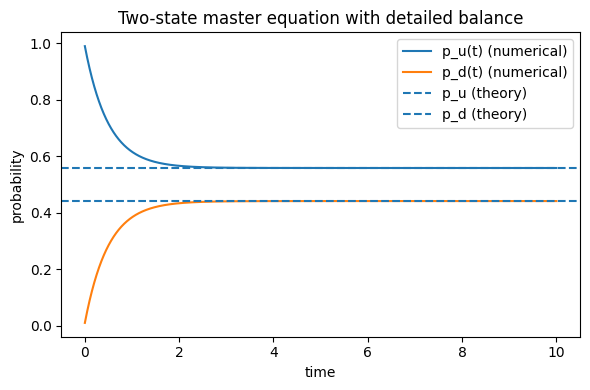

In [27]:

# Initial distribution (intentionally far from equilibrium)
p = np.array([0.99, 0.01], dtype=float)  # [p_u, p_d]
assert np.isclose(p.sum(), 1.0)

# Integrate with simple forward Euler
t_max, dt = 10.0, 1e-3
steps = int(t_max/dt)
ts = np.linspace(0, t_max, steps+1)
traj = np.zeros((steps+1, 2))
traj[0] = p

for n in range(steps):
    p = p + dt * (R @ p)
    # numerical hygiene
    p = np.clip(p, 0, 1)
    p = p / p.sum()
    traj[n+1] = p

p_u, p_d = traj[:,0], traj[:,1]

# Theory: Boltzmann distribution
ratio = np.exp(-beta*DeltaE)           # p_u/p_d
p_u_eq = ratio/(1+ratio)
p_d_eq = 1.0/(1+ratio)

print(f"Rates: R_d->u={R_du:.4f}, R_u->d={R_ud:.4f}, ratio={R_du/R_ud:.4f} (theory e^(-βΔE)={ratio:.4f})")
print(f"Numerical steady state ~ p_u={p_u[-1]:.4f}, p_d={p_d[-1]:.4f}")
print(f"Theoretical steady state  p_u={p_u_eq:.4f}, p_d={p_d_eq:.4f}")

# Plot
plt.figure(figsize=(6,4))
plt.plot(ts, p_u, label="p_u(t) (numerical)")
plt.plot(ts, p_d, label="p_d(t) (numerical)")
plt.axhline(p_u_eq, linestyle="--", label="p_u (theory)")
plt.axhline(p_d_eq, linestyle="--", label="p_d (theory)")
plt.xlabel("time")
plt.ylabel("probability")
plt.title("Two-state master equation with detailed balance")
plt.legend()
plt.tight_layout()
plt.show()

# Cell 2 — Maxwell’s Demon System: Definitions & Notation

This cell formalizes the **model** we’ll simulate: a two–state **demon** that interacts with a stream of two–state **bits**, while exchanging heat with **hot** and **cold** reservoirs. We set up all states, parameters, and transition rules we’ll use to build the rate matrices in later cells.

---

## 1) Components

- **Demon**: two states `u` (upper) and `d` (lower), energy gap **ΔE = E_u − E_d > 0**.
- **Bit**: two states `0` and `1`, **equal energy** (no intrinsic flips).
- **Reservoirs**:
  - **Hot bath** at temperature **T_h** (β_h = 1 / (k_B T_h)) couples to *demon-only* flips.
  - **Cold bath** at temperature **T_c** (β_c = 1 / (k_B T_c)) couples to *cooperative* flips (demon+bit).

- **Tape / interaction**: bits pass by one at a time; each interacts with the demon for a fixed duration **τ**.

---

## 2) State Space

During an interaction, the **joint** demon–bit state is one of:
$$
\{\, 0u,\ 0d,\ 1u,\ 1d \,\}.
$$
We will use this ordering for vectors and matrices:
$$
\mathbf{p}(t) = \big[p_{0u}(t),\ p_{0d}(t),\ p_{1u}(t),\ p_{1d}(t)\big]^T.
$$

> After each interval of length τ, the bit “leaves” and its marginal distribution contributes to the outgoing tape statistics; the demon continues to the next bit with its current marginal state.

---

## 3) Parameters & Useful Reparametrizations

- **Energy gap**: ΔE > 0.
- **Temperatures**: T_h (hot), T_c (cold). Define β_h = 1/(k_B T_h), β_c = 1/(k_B T_c).
- **Intrinsic (hot) flip scale**: γ > 0 (sets time scale of demon-only flips).
- **Dimensionless biases** (convenient hyperbolic-tangent form):
  - $\sigma = \tanh\!\big(\frac{\beta_h \Delta E}{2}\big)$ for hot-bath intrinsic flips.
  - $\omega = \tanh\!\big(\frac{\beta_c \Delta E}{2}\big)$ for cold-bath cooperative flips.
- **Incoming bit bias**: probabilities $p_0, p_1$ with $p_0 + p_1 = 1$;  
  define $\delta = p_0 - p_1 \in [-1,1]$.
- **Interaction time**: τ > 0.

---

## 4) Transition Rules (Rates)

### (A) Intrinsic demon flips (hot bath)
These change only the demon (bit is unaffected):
$$
d \leftrightarrow u
$$
Rates (detailed balance w.r.t. T_h):
$$
\frac{R_{d\to u}}{R_{u\to d}} = e^{-\beta_h \Delta E}, \quad
R_{d\to u} = \gamma(1-\sigma),\quad R_{u\to d} = \gamma(1+\sigma),
$$
with $\sigma = \tanh(\beta_h \Delta E/2)$.

Effect on joint states:
- $0d \leftrightarrow 0u$ with rates $R_{d\to u}, R_{u\to d}$
- $1d \leftrightarrow 1u$ with the same rates.

### (B) Cooperative demon–bit flips (cold bath)
These flip the bit and demon **together**:
$$
0d \leftrightarrow 1u
$$
Rates (detailed balance w.r.t. T_c):
$$
\frac{R_{0d\to 1u}}{R_{1u\to 0d}} = e^{-\beta_c \Delta E}, \quad
R_{0d\to 1u} = (1-\omega),\quad R_{1u\to 0d} = (1+\omega),
$$
with $\omega = \tanh(\beta_c \Delta E/2)$.
> Note: the units can be fixed by choosing the cooperative rate scale as 1 and measuring time accordingly; γ then sets the relative speed of intrinsic vs cooperative dynamics.

There are **no** other cooperative transitions (e.g., $0u \leftrightarrow 1d$ are *not* allowed).

---

## 5) Rate Matrix Structure (during a single interaction)

Using state order $[0u, 0d, 1u, 1d]$, the **rate matrix** $ \mathbf{R} $ has off-diagonal entries given by the allowed transitions:

- Intrinsic (hot):
  - $0u \leftrightarrow 0d$ with $R_{u\to d}, R_{d\to u}$
  - $1u \leftrightarrow 1d$ with $R_{u\to d}, R_{d\to u}$
- Cooperative (cold):
  - $0d \leftrightarrow 1u$ with $1-\omega,\, 1+\omega$

The **diagonal** entries enforce probability conservation: each column sums to zero.

We will build $ \mathbf{R} $ explicitly in code in the next cell.

---

## 6) Interaction Protocol (one bit)

1. **Initialization for this interval**:
   - Draw (or set) the incoming bit distribution: $p_B^{\text{in}} = (p_0, p_1)$.
   - Combine with the demon’s **current** marginal $p_D^{(0)} = (p_u, p_d)$ to get the **joint** initial distribution:
     $$
     \mathbf{p}(0) = p_B^{\text{in}} \otimes p_D^{(0)}.
     $$
2. **Evolve for time τ** under $ \frac{d\mathbf{p}}{dt} = \mathbf{R}\mathbf{p} $ to obtain $\mathbf{p}(\tau)$.
3. **Record outputs**:
   - **Outgoing bit** marginal $p_B^{\text{out}}$ (from $\mathbf{p}(\tau)$).
   - **Updated demon** marginal $p_D^{(1)}$ (becomes the initial demon state for the next bit).
4. **Repeat** for the next incoming bit.

> Over many bits, the demon approaches a **periodic steady state** and the tape statistics (outgoing $p_B^{\text{out}}$) and heat/information fluxes stabilize.

---

## 7) Quantities of Interest

- **Outgoing bit bias**: $\delta' = p_0' - p_1'$ from $p_B^{\text{out}}$.
- **Bit-stream information change** (per bit):  
  $\Delta S_B = S(\delta') - S(\delta)$ where  
  $S(\delta) = -\sum_{b\in\{0,1\}} p_b \ln p_b$ and $p_{0,1} = \frac{1\pm \delta}{2}$.
- **Energy transferred cold → hot per interaction**:
  $$
  Q_{c\to h} = \Phi\,\Delta E,\quad
  \Phi = p_1' - p_1 = \frac{\delta - \delta'}{2}.
  $$
- **Operating regimes**:
  - **Refrigerator**: $Q_{c\to h} > 0$ (energy pumped against the gradient), typically with $\Delta S_B > 0$.
  - **Eraser**: $\Delta S_B < 0$ at the expense of heat flowing hot → cold.

---

## 8) What we’ll code next

- Construct the **4×4 rate matrix** $ \mathbf{R} $ from the rules above.
- Given $p_B^{\text{in}}$, $p_D^{(0)}$, integrate to $t=\tau$ using either:
  - numerical ODE integration, or
  - a matrix exponential $ \mathbf{p}(\tau) = e^{\mathbf{R}\tau}\,\mathbf{p}(0) $.
- Extract the marginals, update the demon, and accumulate statistics (heat and information metrics).

In [28]:
def sigma(beta_h, DeltaE):
    """Intrinsic (hot) bias σ = tanh(β_h ΔE / 2)."""
    return math.tanh(0.5 * beta_h * DeltaE)

def omega(beta_c, DeltaE):
    """Cooperative (cold) bias ω = tanh(β_c ΔE / 2)."""
    return math.tanh(0.5 * beta_c * DeltaE)

def intrinsic_rates(gamma, sig):
    """demon-only flips mediated by hot bath: d<->u."""
    R_d_to_u = gamma * (1.0 - sig)
    R_u_to_d = gamma * (1.0 + sig)
    return R_d_to_u, R_u_to_d

def cooperative_rates(om):
    """cooperative flips 0d<->1u mediated by cold bath."""
    R_0d_to_1u = 1.0 - om
    R_1u_to_0d = 1.0 + om
    return R_0d_to_1u, R_1u_to_0d

# ---------- Build 4×4 rate matrix R ----------

def build_R(DeltaE, Th, Tc, gamma, kB=1.0):
    """
    Build the joint rate matrix R for state order [0u, 0d, 1u, 1d].
    R[i,j] is the rate from state j -> i. Columns sum to zero.
    """
    beta_h = 1.0 / (kB * Th)
    beta_c = 1.0 / (kB * Tc)
    sig = sigma(beta_h, DeltaE)
    om = omega(beta_c, DeltaE)

    R_d_to_u, R_u_to_d = intrinsic_rates(gamma, sig)
    R_0d_to_1u, R_1u_to_0d = cooperative_rates(om)

    # indices: 0:0u, 1:0d, 2:1u, 3:1d
    R = np.zeros((4,4), dtype=float)

    # Intrinsic (hot): 0u <-> 0d
    R[0,1] += R_d_to_u   # 0d -> 0u
    R[1,0] += R_u_to_d   # 0u -> 0d

    # Intrinsic (hot): 1u <-> 1d
    R[2,3] += R_d_to_u   # 1d -> 1u
    R[3,2] += R_u_to_d   # 1u -> 1d

    # Cooperative (cold): 0d <-> 1u
    R[2,1] += R_0d_to_1u  # 0d -> 1u
    R[1,2] += R_1u_to_0d  # 1u -> 0d

    # Diagonals: column-sum zero (probability conservation)
    for j in range(4):
        R[j,j] = -np.sum(R[:,j]) + R[j,j]

    meta = {
        "beta_h": beta_h, "beta_c": beta_c,
        "sigma": sig, "omega": om,
        "R_d->u": R_d_to_u, "R_u->d": R_u_to_d,
        "R_0d->1u": R_0d_to_1u, "R_1u->0d": R_1u_to_0d,
    }
    return R, meta
# ---------- Evolution over one interval τ ----------

def kron_joint(bit_prob, demon_prob):
    """Construct joint vector [0u,0d,1u,1d] from marginals.
       bit_prob = (p0, p1), demon_prob = (p_u, p_d)."""
    p0, p1 = bit_prob
    p_u, p_d = demon_prob
    return np.array([p0*p_u, p0*p_d, p1*p_u, p1*p_d], dtype=float)

def marginals_from_joint(p_joint):
    """Return (bit_prob, demon_prob) marginals from joint [0u,0d,1u,1d]."""
    p0 = p_joint[0] + p_joint[1]
    p1 = p_joint[2] + p_joint[3]
    p_u = p_joint[0] + p_joint[2]
    p_d = p_joint[1] + p_joint[3]
    return (np.array([p0, p1]), np.array([p_u, p_d]))

def evolve_one_interval(R, p0_joint, tau):
    """Evolve joint distribution for time τ under dp/dt = R p using matrix exponential."""
    U = expm(R * tau)
    p_tau = U @ p0_joint
    # numerical hygiene
    p_tau = np.clip(p_tau, 0.0, 1.0)
    s = p_tau.sum()
    if s > 0:
        p_tau /= s
    return p_tau

# ---------- Information & energy metrics ----------

def S_binary_from_delta(delta):
    """Shannon entropy S(δ) for bit with p0=(1+δ)/2, p1=(1-δ)/2 (nats)."""
    p0 = 0.5 * (1.0 + delta)
    p1 = 0.5 * (1.0 - delta)
    eps = 1e-15
    return -(p0 * math.log(max(p0, eps)) + p1 * math.log(max(p1, eps)))

def compute_fluxes(bit_in, bit_out, DeltaE):
    """Return Φ, Q_{c->h}, δ, δ' and ΔS_B (nats)."""
    p0, p1 = bit_in
    p0p, p1p = bit_out
    delta = p0 - p1
    deltap = p0p - p1p
    Phi = p1p - p1              # average 1's produced per interaction
    Q_c_to_h = Phi * DeltaE     # energy transfer cold->hot per interaction
    dSB = S_binary_from_delta(deltap) - S_binary_from_delta(delta)
    return {"Phi": Phi, "Q_c->h": Q_c_to_h, "delta": delta, "delta'": deltap, "ΔS_B": dSB}

# ---------- Demo: run N interactions to approach periodic steady state ----------
def run_demon_tape(
    DeltaE=1.0, Th=3.0, Tc=1.5, gamma=1.0, tau=1.0,
    bit_in=(0.8, 0.2), demon_init=(0.5, 0.5), N=20, kB=1.0
):
    """
    Simulate N sequential interactions.
    Returns history dict with demon and bit marginals, and fluxes per step.
    """
    R, meta = build_R(DeltaE, Th, Tc, gamma, kB=kB)
    hist = {"bit_out": [], "demon": [np.array(demon_init, float)], "flux": [], "meta": meta}

    pD = np.array(demon_init, dtype=float)
    pB_in = np.array(bit_in, dtype=float)

    for _ in range(N):
        p_joint0 = kron_joint(pB_in, pD)
        p_joint_tau = evolve_one_interval(R, p_joint0, tau)
        pB_out, pD_next = marginals_from_joint(p_joint_tau)

        # record
        hist["bit_out"].append(pB_out)
        hist["demon"].append(pD_next)
        hist["flux"].append(compute_fluxes(pB_in, pB_out, DeltaE))

        # next interval: outgoing demon becomes incoming demon; bit_in stays fixed by tape source
        pD = pD_next

    return hist

In [29]:
params = dict(
        DeltaE=2.0,
        Th=1.5,
        Tc=1.2,
        gamma=1.0,
        tau=1.0,
        bit_in=(1.0, 0.0),   # incoming tape bias (p0, p1)
        demon_init=(0.5, 0.5),
        N=300
    )

hist = run_demon_tape(**params)
last_flux = hist["flux"][-1]
print("Meta (σ, ω):", f"sigma={hist['meta']['sigma']:.4f}, omega={hist['meta']['omega']:.4f}")
print("Intrinsic rates d->u / u->d:", f"{hist['meta']['R_d->u']:.4f} / {hist['meta']['R_u->d']:.4f}")
print("Cooperative rates 0d->1u / 1u->0d:", f"{hist['meta']['R_0d->1u']:.4f} / {hist['meta']['R_1u->0d']:.4f}")
print("\nAfter N interactions:")
print(f"  Phi       = {last_flux['Phi']:.6f}")
print(f"  Q_c->h    = {last_flux['Q_c->h']:.6f} (per interaction)")
print(f"  delta,in  = {last_flux['delta']:.6f}")
print(f"  delta,out =", last_flux['delta\''])
print(f"  ΔS_B      = {last_flux['ΔS_B']:.6f} nats")

# Optional: quick view of convergence of delta' (outgoing bit bias)
deltas_out = [bo[0] - bo[1] for bo in hist["bit_out"]]
print("\nOutgoing δ' over interactions (first 10 shown):")
print([float(f"{x:.4f}") for x in deltas_out[:10]])

Meta (σ, ω): sigma=0.5828, omega=0.6823
Intrinsic rates d->u / u->d: 0.4172 / 1.5828
Cooperative rates 0d->1u / 1u->0d: 0.3177 / 1.6823

After N interactions:
  Phi       = 0.136618
  Q_c->h    = 0.273237 (per interaction)
  delta,in  = 1.000000
  delta,out = 0.7267634911542742
  ΔS_B      = 0.398777 nats

Outgoing δ' over interactions (first 10 shown):
[0.7574, 0.7305, 0.7272, 0.7268, 0.7268, 0.7268, 0.7268, 0.7268, 0.7268, 0.7268]


In [30]:
STATE_IDX = {"0u":0, "0d":1, "1u":2, "1d":3}
IDX_TO_BIT_DEMON = {
    0: (0,"u"),
    1: (0,"d"),
    2: (1,"u"),
    3: (1,"d"),
}

def sample_categorical(probs, rng):
    probs = np.clip(probs, 0.0, 1.0)
    s = probs.sum()
    if s <= 0:
        # fallback to uniform if something degenerates
        probs = np.ones_like(probs) / len(probs)
    else:
        probs = probs / s
    return rng.choice(len(probs), p=probs)

def simulate_trajectory(
    N=200,
    DeltaE=2.0, Th=2.5, Tc=1.2, gamma=1.0, tau=1.0,
    bit_in=(0.9, 0.1),              # incoming tape distribution (p0, p1)
    demon_init_state="u",           # initial demon state: "u" or "d"
    kB=1.0,
    seed=42
):
    """
    Simulate a single trajectory of N interactions.
    Returns dict with per-bit records and totals.
    """
    rng = np.random.default_rng(seed)
    R, meta = build_R(DeltaE, Th, Tc, gamma, kB=kB)
    U = expm(R * tau)  # 4x4

    # Demon initial state
    demon_state = demon_init_state  # "u" or "d"
    
    # Records
    incoming_bits = []
    outgoing_bits = []
    demon_states_in = []
    demon_states_out = []
    bit_flips = []   # True if bit changed 0->1 or 1->0 (model only allows 0d<->1u)
    
    # Counts relevant for heat in this model (0->1 at end = +ΔE from cold)
    count_0_to_1 = 0
    count_1_to_0 = 0
    print(U)
    for _ in range(N):
        # Sample incoming bit from tape
        b_in = 0 if rng.random() < bit_in[0] else 1
        
        # Initial joint basis index by (bit, demon)
        if b_in == 0 and demon_state == "u":
            idx0 = STATE_IDX["0u"]
        elif b_in == 0 and demon_state == "d":
            idx0 = STATE_IDX["0d"]
        elif b_in == 1 and demon_state == "u":
            idx0 = STATE_IDX["1u"]
        else:
            idx0 = STATE_IDX["1d"]
        
        # Final joint distribution after one interval: column of U
        # (U @ e_idx0) is just U[:, idx0]
        probs_final = U[:, idx0]
        idx_tau = sample_categorical(probs_final, rng)
        
        # Decode final states
        b_out, demon_out = IDX_TO_BIT_DEMON[idx_tau]
        
        # Record
        incoming_bits.append(b_in)
        outgoing_bits.append(b_out)
        demon_states_in.append(demon_state)
        demon_states_out.append(demon_out)
        
        # Flip check (model only allows 0d<->1u; but end-to-end flip is enough to count)
        flipped = (b_out != b_in)
        bit_flips.append(flipped)
        if b_in == 0 and b_out == 1:
            count_0_to_1 += 1
        elif b_in == 1 and b_out == 0:
            count_1_to_0 += 1
        
        # Demon becomes initial demon for next interval
        demon_state = demon_out

    # Heat tally: per paper, Q_c->h per interaction is ΔE * (fraction of bits that end as 1 minus start p1)
    # For a trajectory-based **count**, using net 0->1 counts is natural:
    Q_c_to_h_total = (count_0_to_1 - count_1_to_0) * DeltaE  # net energy from cold to hot over N interactions

    return {
        "incoming_bits": np.array(incoming_bits),
        "outgoing_bits": np.array(outgoing_bits),
        "demon_in": np.array(demon_states_in, dtype=object),
        "demon_out": np.array(demon_states_out, dtype=object),
        "bit_flips": np.array(bit_flips, dtype=bool),
        "counts": {
            "N": N,
            "0->1": int(count_0_to_1),
            "1->0": int(count_1_to_0),
            "net_0->1": int(count_0_to_1 - count_1_to_0),
        },
        "Q_c->h_total": Q_c_to_h_total,
        "meta": meta,
    }

In [31]:
traj = simulate_trajectory(
        N=500,
        DeltaE=2.0, Th=1.5, Tc=1.2, gamma=1.0, tau=0.8,
        bit_in=(0.95, 0.05),
        demon_init_state="u",
        seed=764543
    )
print("Counts:", traj["counts"])
# Transition matrix:



# bias is number of 0's - number of 1's over total
incoming_0 = np.sum(traj["incoming_bits"] == 0)
incoming_1 = np.sum(traj["incoming_bits"] == 1)
incoming_bias = (incoming_0 - incoming_1) / traj["counts"]["N"]
outgoing_0 = np.sum(traj["outgoing_bits"] == 0)
outgoing_1 = np.sum(traj["outgoing_bits"] == 1)
outgoing_bias = (outgoing_0 - outgoing_1) / traj["counts"]["N"]
print(f"Incoming bias (p1) = {incoming_bias:.4f}, Outgoing bias (p1) = {outgoing_bias:.4f}")
print("Q_c->h_total =", traj["Q_c->h_total"])
print("First 10 (b_in -> b_out):", list(zip(traj["incoming_bits"][:10], traj["outgoing_bits"][:10])))

[[0.36225409 0.15043749 0.06108197 0.00856015]
 [0.57070986 0.71447637 0.39276496 0.08499619]
 [0.04376714 0.07418372 0.14626548 0.10540923]
 [0.02326891 0.06090243 0.3998876  0.80103443]]
Counts: {'N': 500, '0->1': 52, '1->0': 3, 'net_0->1': 49}
Incoming bias (p1) = 0.8800, Outgoing bias (p1) = 0.6840
Q_c->h_total = 98.0
First 10 (b_in -> b_out): [(np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0)), (np.int64(0), np.int64(0))]


\[
T\,p_D^\ = p_D^\,\qquad \sum p_D^\=1,\ p_D^\*\ge 0.
\]

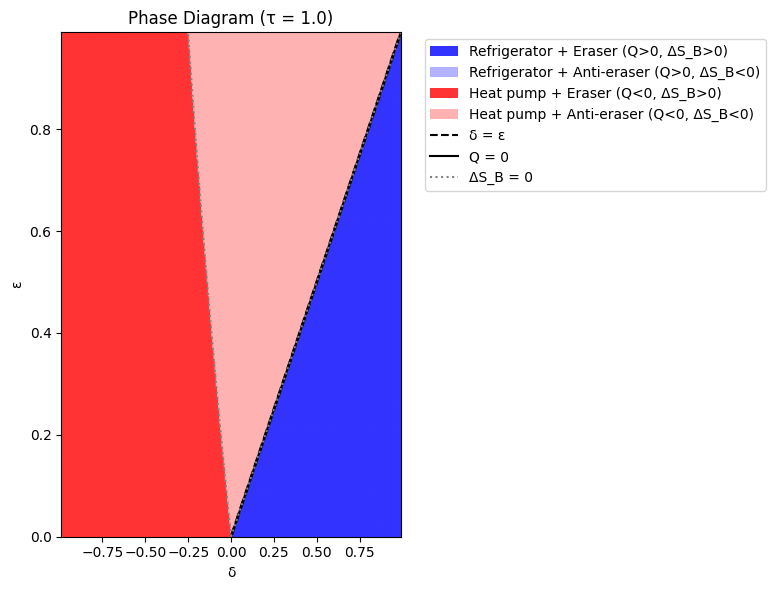

KeyboardInterrupt: 

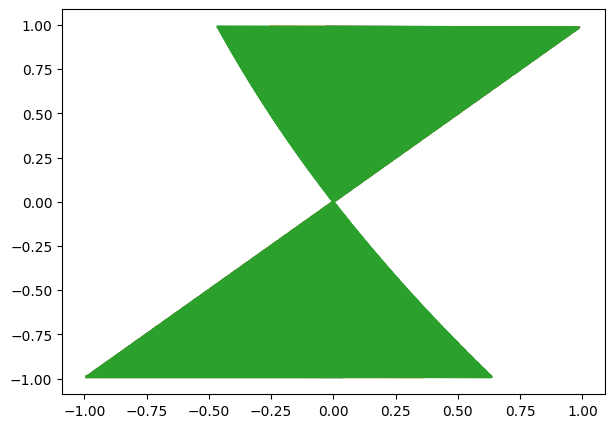

In [32]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.linalg import expm
from matplotlib.patches import Patch

# ---------- Parameter translations ----------

def epsilon_from_T(DeltaE, Th, Tc, kB=1.0):
    """ε = tanh((β_c - β_h) ΔE / 2)"""
    beta_h = 1.0/(kB*Th)
    beta_c = 1.0/(kB*Tc)
    return math.tanh(0.5 * (beta_c - beta_h) * DeltaE)

def omega_from_epsilon(eps, sig):
    """Solve ε = (ω - σ)/(1 - ω σ)  ->  ω = (ε + σ)/(1 + ε σ).
       Clips to (-1+eps, 1-eps) for numerical stability."""
    num = eps + sig
    den = 1.0 + eps*sig
    w = num/den
    # numerical safety
    w = max(min(w, 1.0 - 1e-12), -1.0 + 1e-12)
    return w

def Tc_from_omega(omega, DeltaE, kB=1.0):
    """Given ω = tanh(β_c ΔE / 2), return Tc. β_c = (2/ΔE) artanh(ω)."""
    beta_c = (2.0/DeltaE) * (0.5 * math.log((1.0 + omega)/(1.0 - omega)))  # artanh
    return 1.0/(kB * beta_c)

# ---------- Sweeps ----------

def steady_from_delta_epsilon(
    delta, eps, DeltaE=1.0, Th=3.0, gamma=1.0, tau=1.0,
    demon_init=(0.5, 0.5), N=60, kB=1.0
):
    """
    Compute steady metrics for given (δ, ε) using fixed Th and solved Tc.
    Returns dict with Phi, Q_c->h, ΔS_B, and Tc, omega, sigma.
    """
    # Fix σ by chosen Th
    beta_h = 1.0/(kB*Th)
    sig = math.tanh(0.5 * beta_h * DeltaE)

    # Solve ω from ε and then Tc from ω
    om = omega_from_epsilon(eps, sig)
    om = np.clip(om, -1.0 + 1e-12, 1.0 - 1e-12)
    artanh_om = 0.5 * math.log((1.0 + om)/(1.0 - om))
    beta_c = (2.0/DeltaE) * artanh_om
    Tc = 1.0/(kB * beta_c)

    # Tape from δ
    p0 = 0.5 * (1.0 + delta); p1 = 1.0 - p0
    bit_in = (p0, p1)

    # Run sequential interactions
    hist = run_demon_tape(
        DeltaE=DeltaE, Th=Th, Tc=Tc, gamma=gamma, tau=tau,
        bit_in=bit_in, demon_init=demon_init, N=N, kB=kB
    )
    flux = hist["flux"][-1]
    return {
        "Phi": flux["Phi"],
        "Q_c->h": flux["Q_c->h"],
        "ΔS_B": flux["ΔS_B"],
        "sigma": sig, "omega": om, "Tc": Tc, "Th": Th,
    }

def sweep_phase(
    delta_vals, eps_vals,
    DeltaE=1.0, Th=3.0, gamma=1.0, tau=1.0,
):
    """
    Sweep over grids of δ and ε and return arrays for Q and ΔS_B.
    """
    Q = np.zeros((len(eps_vals), len(delta_vals)), dtype=float)
    dSB = np.zeros_like(Q)
    Phi = np.zeros_like(Q)

    for i, eps in enumerate(eps_vals):
        for j, delta in enumerate(delta_vals):
            res = steady_from_delta_epsilon(
                delta=delta, eps=eps, DeltaE=DeltaE, Th=Th,
                gamma=gamma, tau=tau
            )
            Q[i, j] = res["Q_c->h"]
            dSB[i, j] = res["ΔS_B"]
            Phi[i, j] = res["Phi"]
    return {"Q": Q, "ΔS_B": dSB, "Phi": Phi}

# ---------- Plotting ----------

def plot_phase_diagram(delta_vals, eps_vals, Q, dSB, tau, ax=None, crop_epsilon=True):
    """
    Plot a phase diagram similar to paper Fig. 2:
    - Use Q and ΔS_B to color regions
    - Overlay δ=ε line
    - Add legend explaining colors
    - If Q>0 is refrigerator, else eraser
    - crop_epsilon: if True, only show ε ∈ [0,1] (top half)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    else:
        fig = ax.figure
    
    # Crop data if requested
    if crop_epsilon:
        # Find indices where eps_vals >= 0
        eps_mask = eps_vals >= 0
        eps_vals_plot = eps_vals[eps_mask]
        Q_plot = Q[eps_mask, :]
        dSB_plot = dSB[eps_mask, :]
    else:
        eps_vals_plot = eps_vals
        Q_plot = Q
        dSB_plot = dSB
    
    # Create meshgrid for plotting
    Delta, Eps = np.meshgrid(delta_vals, eps_vals_plot)
    
    # Create composite coloring based on Q and ΔS_B
    # Q > 0: refrigerator (cooling), Q < 0: heat pump (heating)
    # ΔS_B > 0: eraser, ΔS_B < 0: anti-eraser
    
    # Create regions based on signs
    refrigerator_eraser = (Q_plot > 0) & (dSB_plot > 0)      # Blue
    refrigerator_antieraser = (Q_plot > 0) & (dSB_plot < 0)  # Light blue
    heatpump_eraser = (Q_plot < 0) & (dSB_plot > 0)          # Red
    heatpump_antieraser = (Q_plot < 0) & (dSB_plot < 0)      # Light red
    
    # Create color map
    colors = np.zeros((*Q_plot.shape, 4))  # RGBA
    
    # Assign colors
    colors[refrigerator_eraser] = [0.0, 0.0, 1.0, 0.8]        # Blue
    colors[refrigerator_antieraser] = [0.5, 0.5, 1.0, 0.6]    # Light blue
    colors[heatpump_eraser] = [1.0, 0.0, 0.0, 0.8]            # Red
    colors[heatpump_antieraser] = [1.0, 0.5, 0.5, 0.6]        # Light red
    
    # Plot the colored regions
    ax.imshow(colors, extent=[delta_vals.min(), delta_vals.max(), 
                             eps_vals_plot.min(), eps_vals_plot.max()], 
              origin='lower', aspect='auto')
    
    # Overlay δ=ε line (only for visible range)
    diag_line = np.linspace(max(delta_vals.min(), eps_vals_plot.min()), 
                           min(delta_vals.max(), eps_vals_plot.max()), 100)
    ax.plot(diag_line, diag_line, 'k--', linewidth=2, label='δ = ε')
    
    # Add contour lines for Q=0 and ΔS_B=0
    ax.contour(Delta, Eps, Q_plot, levels=[0], colors=['black'], linewidths=1.5, linestyles='-')
    ax.contour(Delta, Eps, dSB_plot, levels=[0], colors=['gray'], linewidths=1.5, linestyles=':')
    
    # Create custom legend
    legend_elements = [
        Patch(facecolor=[0.0, 0.0, 1.0, 0.8], label='Refrigerator + Eraser (Q>0, ΔS_B>0)'),
        Patch(facecolor=[0.5, 0.5, 1.0, 0.6], label='Refrigerator + Anti-eraser (Q>0, ΔS_B<0)'),
        Patch(facecolor=[1.0, 0.0, 0.0, 0.8], label='Heat pump + Eraser (Q<0, ΔS_B>0)'),
        Patch(facecolor=[1.0, 0.5, 0.5, 0.6], label='Heat pump + Anti-eraser (Q<0, ΔS_B<0)'),
        plt.Line2D([0], [0], color='k', linestyle='--', label='δ = ε'),
        plt.Line2D([0], [0], color='black', linestyle='-', label='Q = 0'),
        plt.Line2D([0], [0], color='gray', linestyle=':', label='ΔS_B = 0')
    ]
    
    ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlabel('δ')
    ax.set_ylabel('ε')
    ax.set_title(f'Phase Diagram (τ = {tau})')
    ax.set_xlim(delta_vals.min(), delta_vals.max())
    ax.set_ylim(eps_vals_plot.min(), eps_vals_plot.max())
    
    return ax

    

def plot_eraser_boundary_vs_tau(
    delta_vals, eps_vals, taus,
    DeltaE=1.0, Th=3.0, gamma=1.0
):
    """
    Plot multiple ΔS_B=0 boundaries for different τ values (approximate).
    """
    fig, ax = plt.subplots(figsize=(7,5))

    # δ=ε line
    dline = np.linspace(min(delta_vals), max(delta_vals), 400)
    ax.plot(dline, dline, 'k--', linewidth=1.2, label="δ = ε")

    colors = ["C0", "C1", "C2", "C3", "C4", "C5"]
    for idx, tau in enumerate(taus):
        grid = sweep_phase(delta_vals, eps_vals, DeltaE=DeltaE, Th=Th, gamma=gamma, tau=tau)
        dSB = grid["ΔS_B"]

        # Find ΔS_B=0 approximate contour
        xs, ys = [], []
        for i, eps in enumerate(eps_vals):
            row = dSB[i, :]
            for j in range(len(delta_vals) - 1):
                if row[j] == 0:
                    xs.append(delta_vals[j]); ys.append(eps)
                elif row[j] * row[j+1] < 0:
                    t = abs(row[j]) / (abs(row[j]) + abs(row[j+1]))
                    delta_zero = (1-t)*delta_vals[j] + t*delta_vals[j+1]
                    xs.append(delta_zero); ys.append(eps)

        if xs:
            ax.plot(xs, ys, '-', color=colors[idx % len(colors)], label=f"ΔS_B=0 (τ={tau})", linewidth=2.0)

    ax.set_title("Eraser boundary (ΔS_B=0) vs τ")
    ax.set_xlabel("δ")
    ax.set_ylabel("ε")
    ax.set_xlim(min(delta_vals), max(delta_vals))
    ax.set_ylim(min(eps_vals), max(eps_vals))
    ax.legend()
    plt.tight_layout()
    return fig, ax

def plot_sections(delta_vals, eps_fixed_list, DeltaE=1.0, Th=3.0, gamma=1.0, tau=1.0):
    """
    Plot Q_c->h and ΔS_B as functions of δ for several fixed ε values.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), sharex=True)
    for eps in eps_fixed_list:
        grid = sweep_phase(delta_vals, [eps], DeltaE=DeltaE, Th=Th, gamma=gamma, tau=tau)
        Q = grid["Q"][0]
        dSB = grid["ΔS_B"][0]
        ax1.plot(delta_vals, Q, label=f"ε={eps:.2f}")
        ax2.plot(delta_vals, dSB, label=f"ε={eps:.2f}")
    ax1.axhline(0, color="k", linestyle="--", linewidth=1)
    ax2.axhline(0, color="k", linestyle="--", linewidth=1)
    ax1.set_title("Qc→h vs δ")
    ax2.set_title("ΔS_B vs δ")
    ax1.set_xlabel("δ"); ax2.set_xlabel("δ")
    ax1.set_ylabel("Qc→h"); ax2.set_ylabel("ΔS_B (nats)")
    ax1.legend(); ax2.legend()
    plt.tight_layout()
    return fig, (ax1, ax2)

# ---------- Demo: generate figures ----------


# Global parameters (feel free to tweak)
DeltaE = 1.0
Th = 3.0
gamma = 1.0

# Grids
delta_vals = np.linspace(-0.99, 0.99, 301)
eps_vals   = np.linspace(-0.99, 0.99, 301)

# Single τ phase diagram
tau = 1.0
grid = sweep_phase(delta_vals, eps_vals, DeltaE=DeltaE, Th=Th, gamma=gamma, tau=tau)
ax = plot_phase_diagram(delta_vals, eps_vals, grid["Q"], grid["ΔS_B"], tau=tau)
plt.tight_layout()
plt.show()

# Multiple τ eraser boundaries (approximate)
taus = [0.1, 1.0, 2.0, 5.0]  # 5.0 ~ approaches large-τ limit visually
fig, ax = plot_eraser_boundary_vs_tau(delta_vals, eps_vals, taus, DeltaE=DeltaE, Th=Th, gamma=gamma)
plt.show()

# Sections for intuition at fixed ε
eps_fixed_list = [-0.6, -0.2, 0.0, 0.3, 0.6]
fig, _ = plot_sections(delta_vals, eps_fixed_list, DeltaE=DeltaE, Th=Th, gamma=gamma, tau=tau)
plt.show()